RealNVP - GLOW, FFJORD 모델로 발전

In [ ]:
# 노멀라이징 모델 : 디코딩 함수는 인코딩 함수의 역함수이고 빠르게 계산할 수 있다
# 변수변환 : 확률분포,적분,미분
# 확률밀도 함수 변환, 적분 변수 변환
# 야코비 행렬식

In [ ]:
# RealNVP 튜토리얼
# https://keras.io/examples/generative/real_nvp/

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [ ]:
data = make_moons(3000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

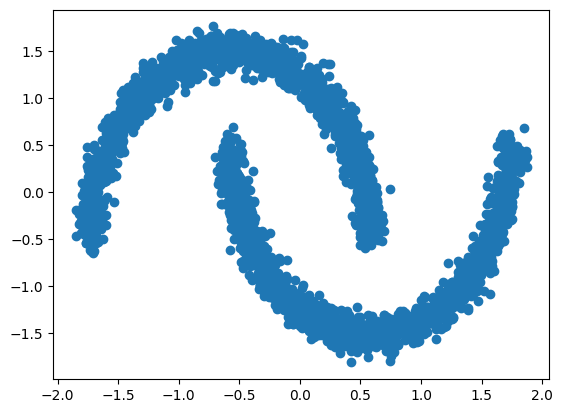

In [ ]:
plt.scatter(
    normalized_data.numpy()[:,0],normalized_data.numpy()[:,1]
)
plt.show()

In [ ]:
# 초승달 데이터셋은 잡음이 있는 2D 데이터셋
# 잡음이 있고 정규화되지 않은 3000개 포인트로 구성ㄷ
# 전처리..--> 평균이 0이고 표준편차가 1이 되도록 정규화

In [ ]:
# 만돌리니 조르조 마리아...
# 위의 데이터셋과 비슷한 분포를 따르는 2D포인트를 생성하는 RealNVP모델
# 새로운 층 : 커플링 층
# 입력x -> scale factor
#       -> translation factor

In [ ]:
# Creating a custom layer with keras API.
output_dim = 256
reg = 0.01


def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

In [ ]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super().__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.

        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

In [ ]:
model = RealNVP(num_coupling_layers=6)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

history = model.fit(
    normalized_data, batch_size=256, epochs=300, verbose=2, validation_split=0.2
)

Text(0.5, 0, 'epoch')

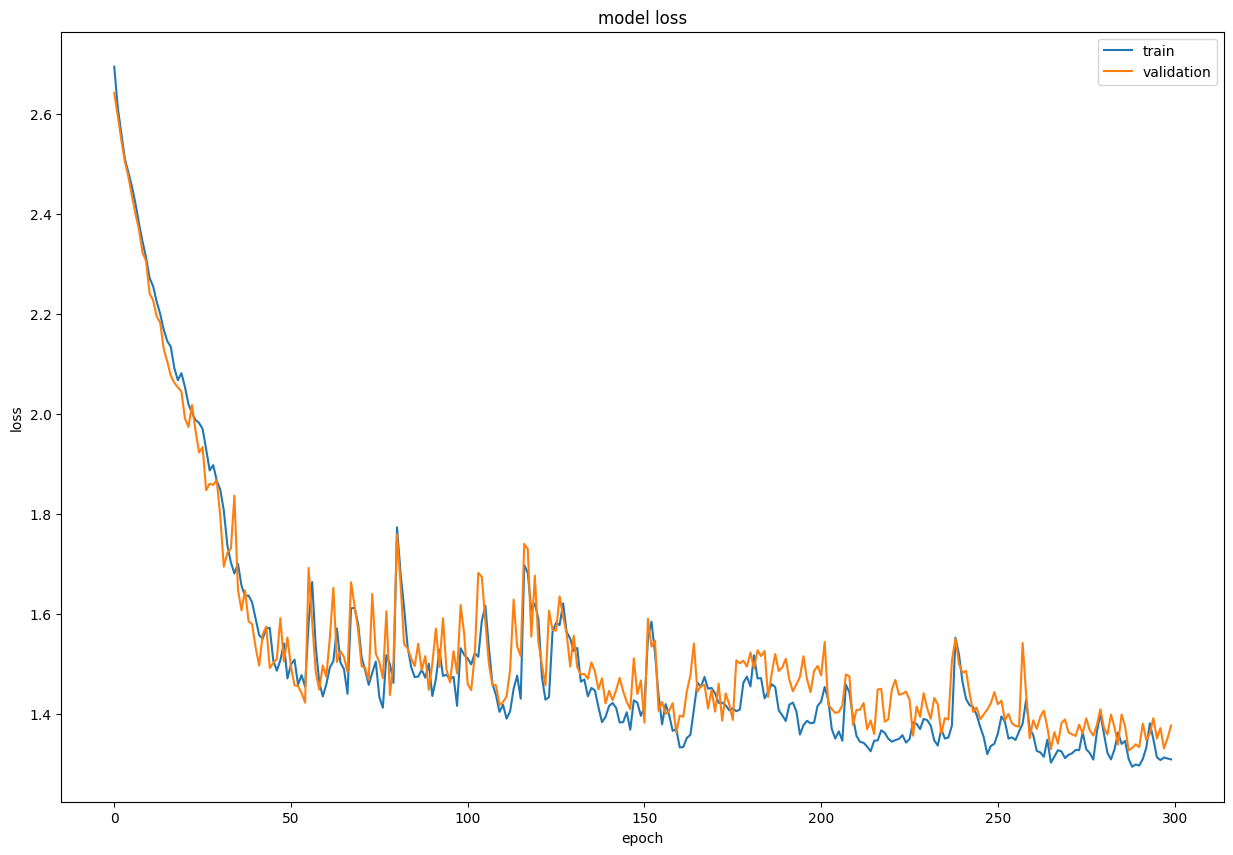

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

157/157 [==============================] - 1s 8ms/step


(-2.0, 2.0)

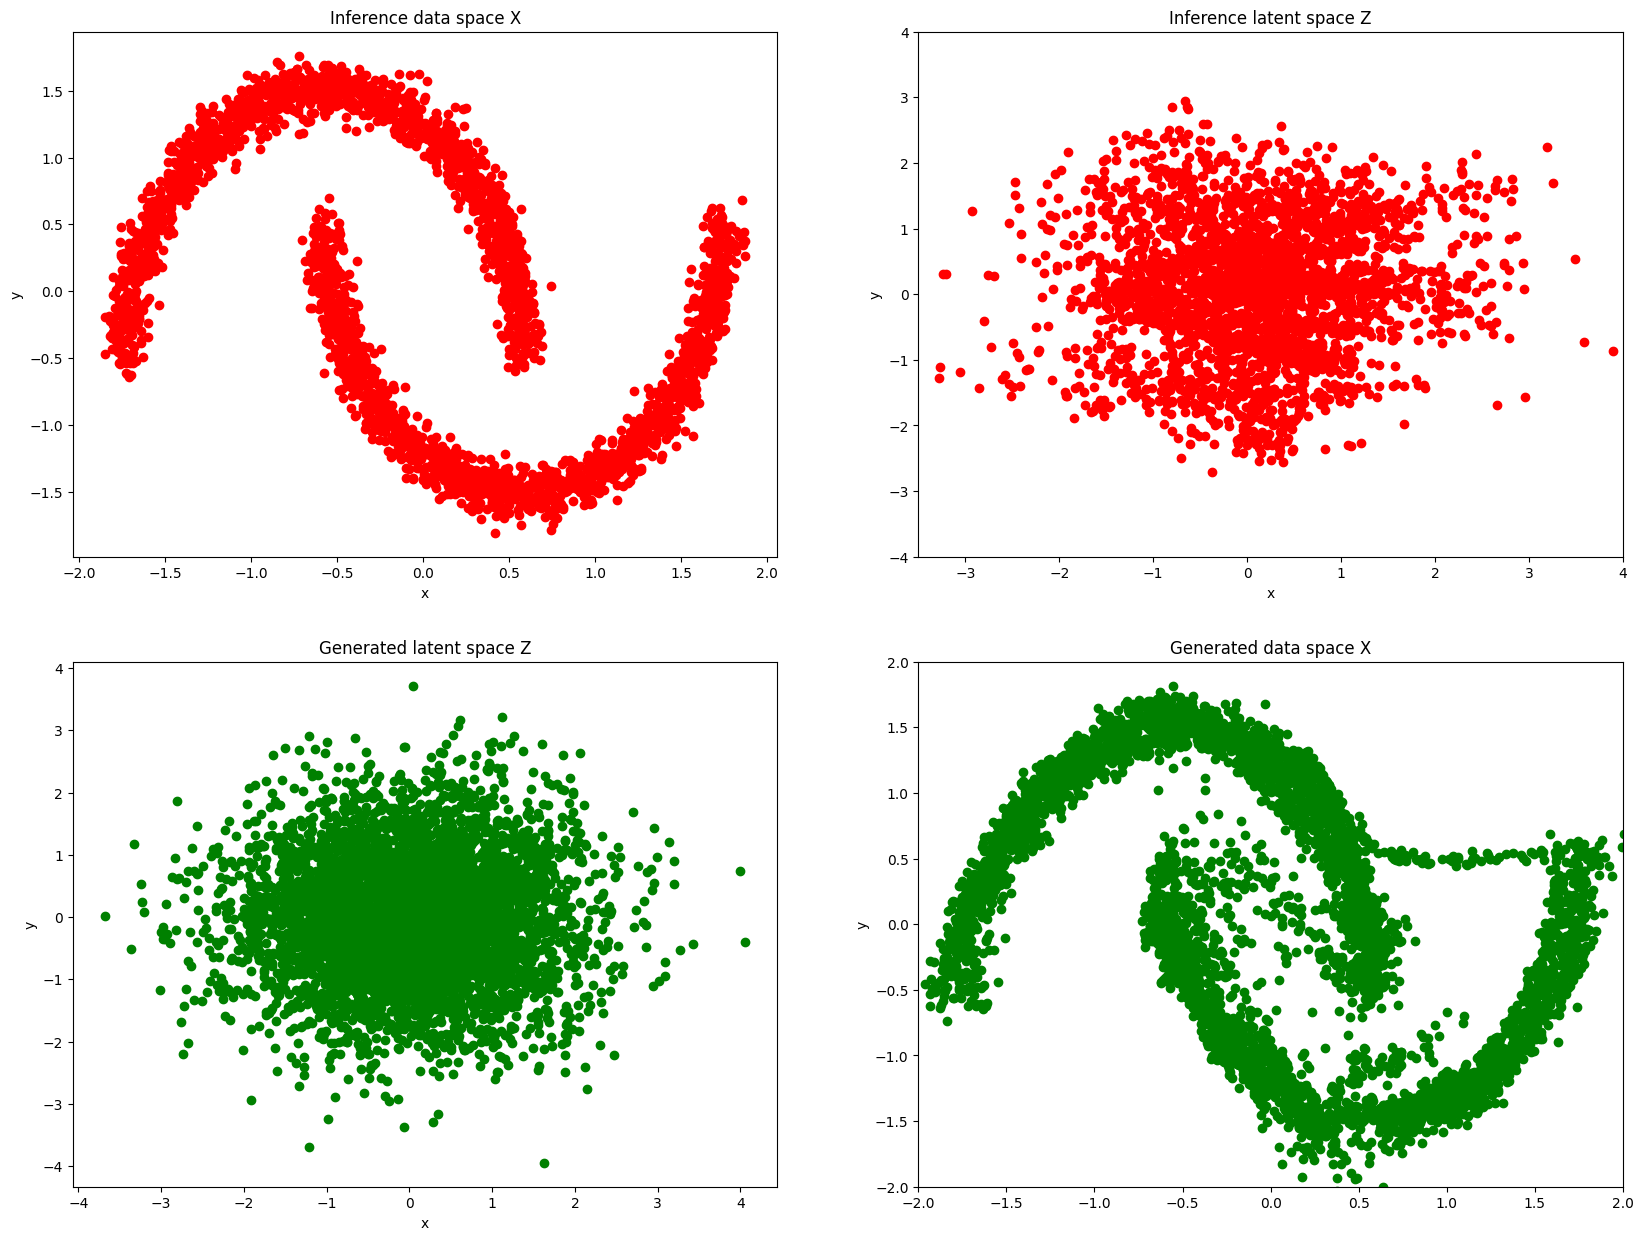

In [ ]:
# From data to latent space.
z, _ = model(normalized_data)

# From latent space to data.
samples = model.distribution.sample(5000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])